# 1. Importing the libraries

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense 

from sklearn.preprocessing import MinMaxScaler

# 2. Read the Dataset

In [2]:
df=pd.read_csv('NSE-Tata.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


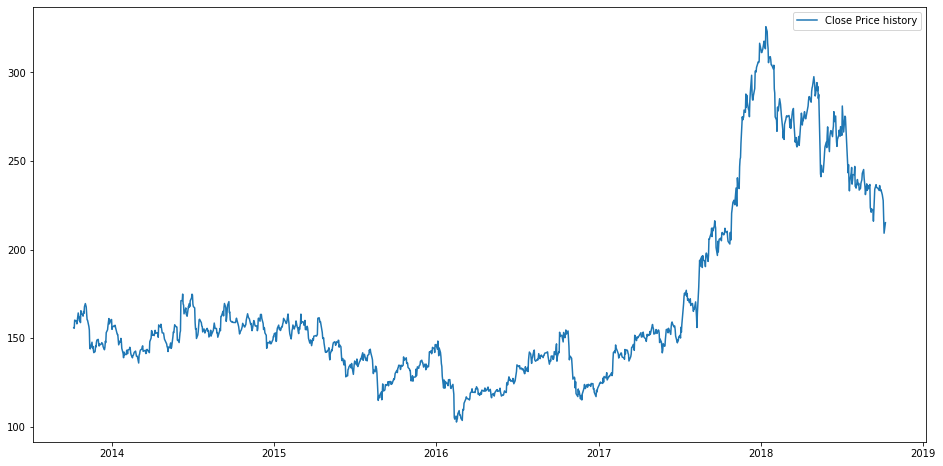

In [3]:
# 3. Analyze the closing prices from dataframe:
df['Date']=pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label="Close Price history")
plt.legend(loc='best')
plt.show()

# 4. Sort the dataset on date time and filter "Date" and "Close" columns:

In [4]:
data=df.sort_index(ascending=True,axis=0)

new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data["Date"][i]
    new_dataset["Close"][i]=data["Close"][i]

In [5]:
new_dataset.head()

,Date,Close
0,2013-10-08 00:00:00,155.8
1,2013-10-09 00:00:00,155.55
2,2013-10-10 00:00:00,160.15
3,2013-10-11 00:00:00,160.05
4,2013-10-14 00:00:00,159.45


# 5. Normalize the new filtered dataset:

In [7]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values 

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

new_dataset.index=new_dataset.Date
new_dataset.drop('Date',axis=1,inplace=True)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(new_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))


# 6. Build and train the LSTM model:

In [8]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error',optimizer='adam')

lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

927/927 - 24s - loss: 9.3303e-04


In [9]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

# 7. Take a sample of a dateset to make stock price predictions using the LSTM model: 

In [10]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

# 8. Save the LSTM model:

In [11]:
lstm_model.save("saved_model.h5")

# 9. Visualize the predicted stock costs with actual stock costs:


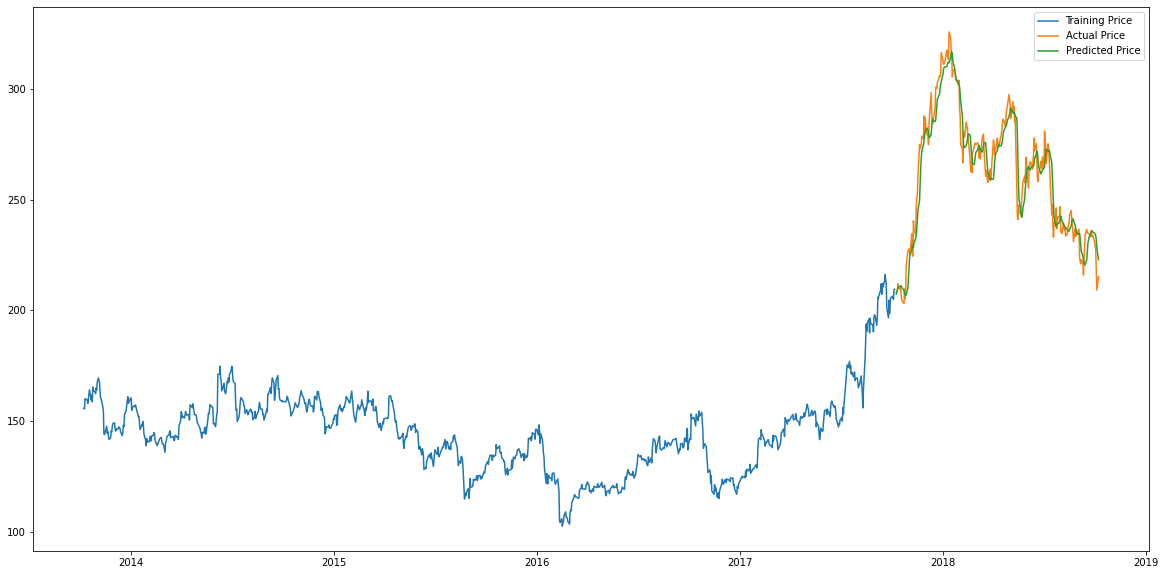

In [12]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data['Close'],label='Training Price')
plt.plot(valid_data['Close'],label='Actual Price')
plt.plot(valid_data['Predictions'],label='Predicted Price')
plt.legend(loc='best')
plt.show()